In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import v2
import torch.nn.functional as F

from tqdm import tqdm

torch_seed = 37
t.manual_seed(torch_seed)

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])

In [3]:
fav_pic_index = 28621
data_root = 'imagenet'
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]
fav_image_inf = imagenet_val_inference[fav_pic_index][0].unsqueeze(0)
toImage = v2.ToPILImage()

test_size = 64
train_size = test_size
dataloader = t.utils.data.DataLoader(dataset=imagenet_val_inference, batch_size=test_size, shuffle = True)

train_images, _ = next(iter(dataloader))
test_images, _ = next(iter(dataloader))
train_images = train_images.to(device)
test_images = test_images.to(device)

In [4]:
from utils.diffeo_container import sparse_diffeo_container

sparse_diffeos = sparse_diffeo_container(224, 224)
sparse_diffeos.sparse_AB_append(2,2,1,0.5,1)
sparse_diffeos.get_all_grid()
sparse_diffeos.to(device)
# inv_diffeo = sparse_diffeos.get_inverse_grid()
# inv_diffeo.to(device)

In [5]:
class add_bias_to_AB(nn.Module):
  def __init__(self, AB, extra_freq_scaling = 1):
    # grid should have the shape of a grid_sample grid, i.e. (Channel, X, Y, 2)
    super().__init__()
    _, _, x_cutoff, y_cutoff = AB.shape
    self.AB = F.pad(AB,(0,(extra_freq_scaling) * y_cutoff, 0, (extra_freq_scaling) * x_cutoff),mode = 'constant', value = 0)
    # self.bias = nn.Parameter(self.AB.abs().sum() * (t.randint_like(self.AB, 1) - 1/2)/self.AB.numel())
    # self.bias = nn.Parameter(t.rand_like(self.AB))
    self.bias = nn.Parameter(t.rand_like(self.AB)/self.AB.numel())
    self.result = AB
  def forward(self):
    self.result = self.bias + self.AB
    return self.result
  @property
  def result_magnitude(self):
    return self.result[0].detach().abs().sum(), self.result[1].detach().abs().sum()
  @property
  def bias_magnitude(self):
    return self.bias[0].detach().abs().sum(), self.bias[1].detach().abs().sum()
  @property
  def original_magnitude(self):
    return self.AB[0].detach().abs().sum(), self.AB[1].detach().abs().sum()

In [6]:
AB_original = t.cat([t.stack(sparse_diffeos.A), t.stack(sparse_diffeos.B)])
AB = add_bias_to_AB(-AB_original.to(device), extra_freq_scaling = 10).to(device)
# AB = add_bias_to_AB(t.zeros_like(-AB_original).to(device), extra_freq_scaling = 0).to(device)
loss_fn = nn.MSELoss()
loss_cos = nn.CosineSimilarity()
loss_l1 = nn.L1Loss()
inv_loss_hist = []
cos_loss_hist = []
cos_sim_hist = []
AB_mag = []

In [7]:
from utils.distortion import compose_diffeo_from_left, create_grid_sample
from utils.diffeo_container import diffeo_container
from utils.get_model_activation import get_flatten_children

optimizer = t.optim.Adagrad(AB.parameters(), lr = 0.1)

num_epochs = 500
# ref_grid = compose_diffeo_from_left(inv_grid[0],sparse_diffeos[0]).to(device)
id_grid = sparse_diffeos.get_id_grid()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    new_AB = AB()
    with t.device(device):
        grid = create_grid_sample(224, 224, new_AB[0], new_AB[1])
    un_distorted = compose_diffeo_from_left(grid,sparse_diffeos[0])
    unreg_loss = loss_fn(un_distorted, id_grid)
    loss = unreg_loss * (1 + 0.1 * AB.result.abs().sum()/AB.AB.abs().sum())
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)

    if (epoch) % 50 == 0:
          with t.no_grad(): 
            inv_loss_hist.append(unreg_loss.item())
            AB_mag.append(AB.result.abs().sum().item()/2)
            AB.bias[t.abs(AB.bias) < 1e-7] = 0
          # print(loss.item())

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 500/500 [00:03<00:00, 140.34it/s]


/tmp/ipykernel_267908/3804172420.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[2].matshow(np.log10(AB.result[0,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
/tmp/ipykernel_267908/3804172420.py:9: RuntimeWarning: divide by zero encountered in log10
  cb = axes[3].matshow(np.log10(AB.result[1,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)


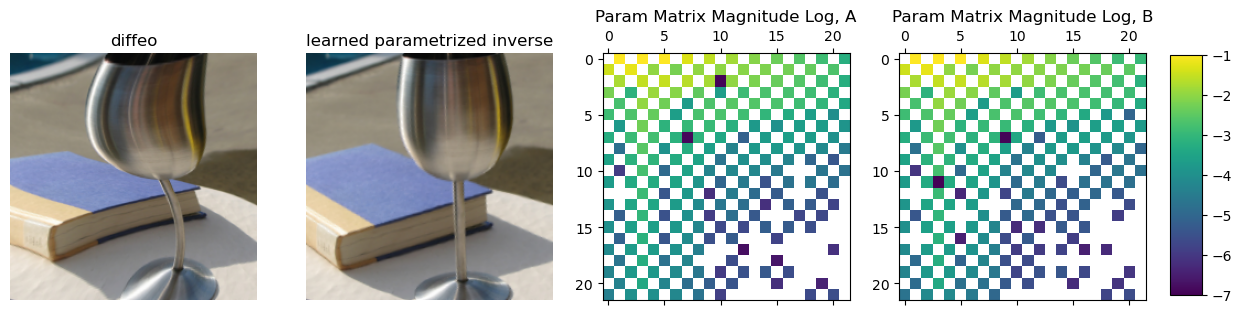

In [8]:
fig, axes = plt.subplots(1, 4, figsize = (4 * 4 ,4))
axes[0].imshow(toImage(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0].squeeze()))
axes[0].set_title('diffeo')
axes[1].imshow(toImage(F.grid_sample(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0], grid, align_corners = True).squeeze()))
axes[1].set_title('learned parametrized inverse')

axes[2].matshow(np.log10(AB.result[0,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
axes[2].set_title('Param Matrix Magnitude Log, A')
cb = axes[3].matshow(np.log10(AB.result[1,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
axes[3].set_title('Param Matrix Magnitude Log, B')

fig.subplots_adjust(right=0.835)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(cb, cax=cbar_ax)
[ax.axis('off') for i, ax in enumerate(axes) if i<2];

In [55]:
from utils.distortion import compose_diffeo_from_left, create_grid_sample
from utils.diffeo_container import diffeo_container
from utils.get_model_activation import get_flatten_children

def sharpen_net(in_channels, kernel_size=3, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size = kernel_size, **kwargs)
        )

def inv_diff_hook(grid, x_res, y_res, sharpen_filter = None, align_corners = True, **kwargs):
    if grid.shape[-3:] != (x_res, y_res, 2):        
        raise Exception('grid has wrong shape!')
    def hook(module, input, output):
        inverse = F.grid_sample(output, grid, align_corners = align_corners, **kwargs)
        if sharpen_filter != None:
            output = inverse + 0.1 * sharpen_filter(inverse)
            return output
        return inverse
    return hook

In [91]:
### learn a sharpening
sharpen_filter = sharpen_net(24, padding = 'same', groups = 24, bias = False).to(device)
optimizer = t.optim.Adagrad(sharpen_filter.parameters(), lr = 1e-1)

model_layer = get_flatten_children(ENV2)
steering_layer = model_layer[5 - 1]
x_res = 112
y_res = 112
# optimizer = t.optim.SGD(AB.parameters(), lr = 1e-4)
# optimizer = t.optim.Adam(AB.parameters(), lr = 0.1)

num_epochs = 500
# ref_grid = compose_diffeo_from_left(inv_grid[0],sparse_diffeos[0]).to(device)
id_grid = sparse_diffeos.get_id_grid()
ref = ENV2(train_images)

with t.device(device):
    grid = create_grid_sample(x_res, y_res, new_AB[0], new_AB[1]).detach()
    grid = grid.expand(test_size, -1, -1, -1)

sparse_diffeos.diffeos[0] = sparse_diffeos.diffeos[0].expand(test_size,-1,-1,-1)


for epoch in tqdm(range(num_epochs)):    
    optimizer.zero_grad()
    my_hook = inv_diff_hook(grid, x_res, y_res, sharpen_filter, mode = 'nearest')
    hook = steering_layer.register_forward_hook(my_hook)
    result = ENV2(sparse_diffeos(train_images.to(device), in_inference=True))
    unreg_loss = loss_fn(ref, result)
    loss = unreg_loss 
    unreg_loss.backward()
    optimizer.step()

    hook.remove()


    if (epoch) % 10 == 0:
          with t.no_grad(): 
            cos_loss_hist.append(unreg_loss.item())
            cos_sim_hist.append(loss_cos(ref, result).mean().item())

# with t.no_grad():
#     print(loss_cos(ref, result).mean().item())
#     print(loss_cos(ref, ENV2(sparse_diffeos(fav_image_inf.to(device), in_inference=True))).mean().item())

100%|██████████| 500/500 [01:32<00:00,  5.38it/s]


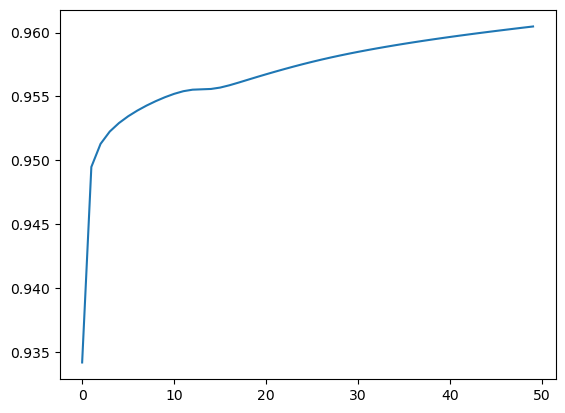

In [92]:
plt.plot(cos_sim_hist)

In [12]:
### learn a grid_sample

model_layer = get_flatten_children(ENV2)
steering_layer = model_layer[5 - 1]
x_res = 112
y_res = 112
# optimizer = t.optim.SGD(AB.parameters(), lr = 1e-4)
# optimizer = t.optim.Adam(AB.parameters(), lr = 0.1)
optimizer = t.optim.Adagrad(AB.parameters(), lr = 1e-3)
# optimizer = t.optim.SGD(AB.parameters(), lr = 1e-1)
# scheduler = t.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr=1e-2, patience = 5)

num_epochs = 1000
# ref_grid = compose_diffeo_from_left(inv_grid[0],sparse_diffeos[0]).to(device)
id_grid = sparse_diffeos.get_id_grid()
ref = ENV2(train_images.to(device))
sparse_diffeos.diffeos[0] = sparse_diffeos.diffeos[0].expand(test_size,-1,-1,-1)

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    new_AB = AB()
    with t.device(device):
        grid = create_grid_sample(x_res, y_res, new_AB[0], new_AB[1])
    hook = steering_layer.register_forward_hook(inv_diff_hook(grid, x_res, y_res))
    result = ENV2(sparse_diffeos(train_images.to(device), in_inference=True))
    unreg_loss = loss_fn(ref, result)
    loss = unreg_loss * (1 + 0.1 * AB.result.abs().sum()/AB.AB.abs().sum())
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)

    hook.remove()

    if (epoch) % 20 == 0:
          with t.no_grad(): 
            cos_loss_hist.append(unreg_loss.item())
            cos_sim_hist.append(loss_cos(ref, result).mean().item())
            AB_mag.append(AB.result.abs().sum().item()/2)
            AB.bias[t.abs(AB.bias) < 1e-7] = 0

with t.no_grad():
    print(loss_cos(ref, result).mean().item())
    print(loss_cos(ref, ENV2(sparse_diffeos(fav_image_inf.to(device), in_inference=True))).mean().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: inv_diff_hook() missing 1 required positional argument: 'sharpen_filter'

0.01514421496540308
1.0623420476913452


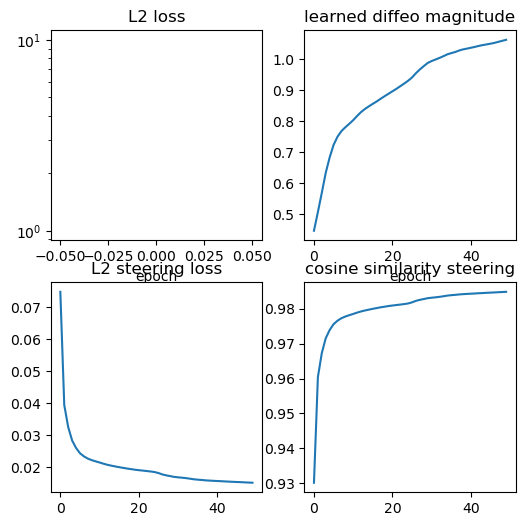

In [10]:
fig, axes = plt.subplots(2,2, figsize = (6,6))
axes[0,0].plot(inv_loss_hist)
axes[0,0].set_yscale('log')
axes[0,0].set_title('L2 loss')
axes[0,0].set_xlabel('epoch')
axes[0,1].plot(AB_mag)
axes[0,1].set_title('learned diffeo magnitude')
axes[0,1].set_xlabel('epoch')

axes[1,0].plot(cos_loss_hist)
axes[1,0].set_title('L2 steering loss')

axes[1,1].plot(cos_sim_hist)
axes[1,1].set_title('cosine similarity steering')

print(cos_loss_hist[-1])
print(AB_mag[-1])

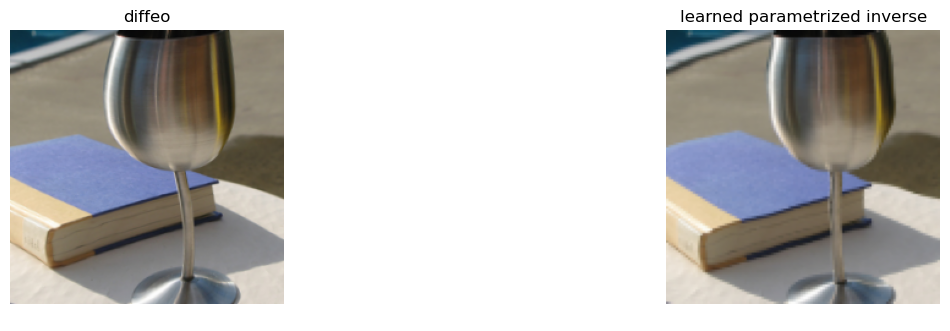

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (12,4))
axes[0].imshow(toImage(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0].squeeze()))
axes[0].set_title('diffeo')
# axes[1].imshow(toImage(inv_grid(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0])[0].squeeze()))
# axes[1].set_title('learned inverse')
axes[2].imshow(toImage(F.grid_sample(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0], grid, align_corners = True).squeeze()))
axes[2].set_title('learned parametrized inverse')
[ax.axis('off') for ax in axes];

/tmp/ipykernel_2393902/692275119.py:2: RuntimeWarning: divide by zero encountered in log10
  axes[0].matshow(np.log10(AB.result[0,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
/tmp/ipykernel_2393902/692275119.py:3: RuntimeWarning: divide by zero encountered in log10
  cb = axes[1].matshow(np.log10(AB.result[1,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)


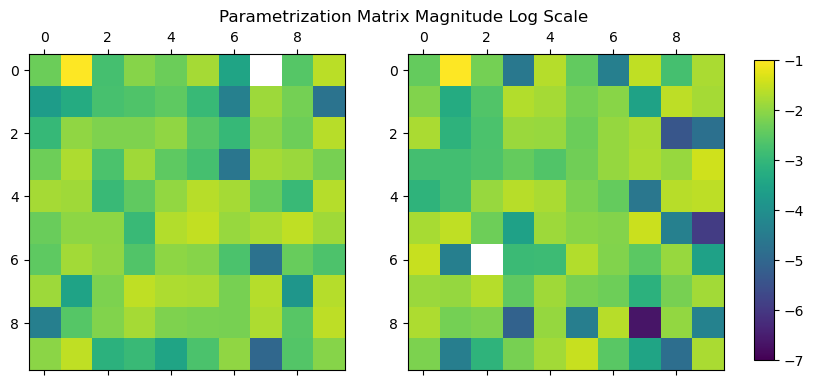

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].matshow(np.log10(AB.result[0,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
cb = axes[1].matshow(np.log10(AB.result[1,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(cb, cax=cbar_ax)
fig.suptitle('Parametrization Matrix Magnitude Log Scale', y=0.9);

In [95]:
def inv_diff_hook(grid_1, ref_grid, x_res, y_res, normalization = None):
    #if grid_1.shape[-3:] != (x_res, y_res, 2) or ref_grid.shape[-3:] != (x_res, y_res, 2):        
    #    raise Exception('grid has wrong shape!')
    def hook(module, input, output):
            U_ref, S_ref, Vh_ref = t.linalg.svd(output)
            inv = F.grid_sample(output, ref_grid, align_corners = True, mode = 'bilinear')
            activation['original'] = output.detach()
            activation['bilinear'] = inv.detach()
            activation['nearest'] = F.grid_sample(output, grid_1, align_corners = True, mode = 'nearest').detach()
            U, S, Vh = t.linalg.svd(inv)
            output = t.einsum('...ik, ...k, ...kj -> ...ij', U, S_ref, Vh)
            activation['svd_corr'] = output
            if normalization != None:
                  return normalization(output)
            return output
    return hook


def get_activation_hook(key: str):
      def hook(module, input, output):
            activation[key] = output.detach()
            return output
      return hook

In [93]:
from utils.distortion import create_grid_sample

x_res = 112
y_res = 112
ref_grid = sparse_diffeos.get_id_grid(224, 224).to(device)


steering_layer_num = 5

inv_AB = new_AB.detach()

activation = {}

with t.device(device):
    grid_1 = create_grid_sample(x_res, y_res, sparse_diffeos.A[0].to(device), sparse_diffeos.B[0].to(device))
    grid_2 = create_grid_sample(x_res, y_res, inv_AB[0], inv_AB[1])

grid_1 = grid_1.expand(test_size, -1, -1, -1)
grid_2 = grid_2.expand(test_size, -1, -1, -1)

# test_grid = grid.repeat(test_size,1,1,1)

distorted = F.grid_sample(test_images, sparse_diffeos.diffeos[0].expand(test_size, -1, -1, -1), align_corners = True)

test_ref = ENV2(test_images)
dist_ref = ENV2(distorted)

model_layer = get_flatten_children(ENV2)
steering_layer = model_layer[steering_layer_num - 1]
retreieve_hook_pre = steering_layer.register_forward_hook(get_activation_hook('pre-bilinear'))
hook = steering_layer.register_forward_hook(
    inv_diff_hook(
        grid_2, x_res, y_res, sharpen_filter = sharpen_filter, mode = 'nearest'))
retreieve_hook_post = steering_layer.register_forward_hook(get_activation_hook('post-bilinear-sharpen'))


result = ENV2(distorted)

# retreieve_hook_pre.remove()
# hook.remove()
# retreieve_hook_post.remove()


# hook = steering_layer.register_forward_hook(
#     inv_diff_hook(
#         grid_2, x_res, y_res, mode = 'nearest'))
# retreieve_hook_post = steering_layer.register_forward_hook(get_activation_hook('post-nn'))

# nn_result = ENV2(distorted)

# hook.remove()
# retreieve_hook_post.remove()

# hook = steering_layer.register_forward_hook(
#     inv_diff_hook(
#         grid_2, x_res, y_res, mode = 'bilinear'))
# retreieve_hook_post = steering_layer.register_forward_hook(get_activation_hook('post-bilinear'))

# ns_result = ENV2(distorted)

# hook.remove()
# retreieve_hook_post.remove()

In [94]:
with t.no_grad(): 
    print(loss_cos(test_ref,dist_ref).mean()), print(loss_cos(test_ref,ns_result).mean()), print(loss_cos(test_ref,result).mean()), print(loss_cos(test_ref,nn_result).mean())

tensor(0.9009, device='cuda:0')
tensor(0.8494, device='cuda:0')
tensor(0.9192, device='cuda:0')
tensor(0.9225, device='cuda:0')


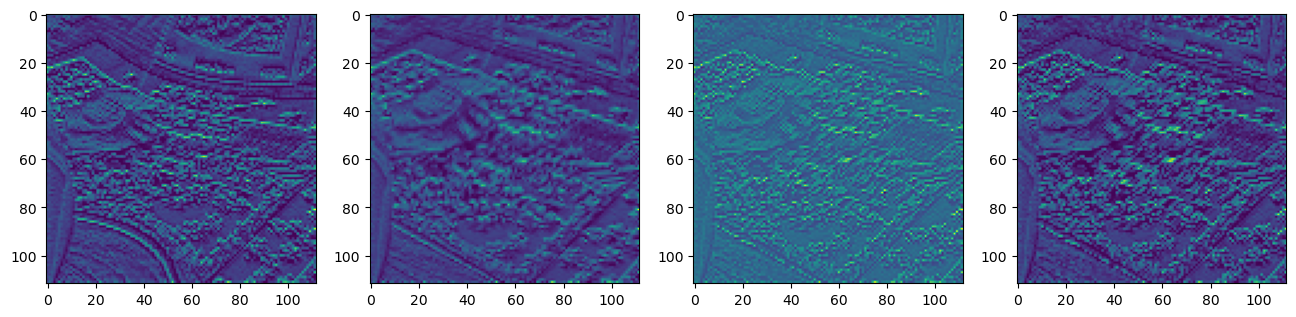

In [89]:
img = 37
channel = 20
fig, axes = plt.subplots(1, 4, figsize = (16,4))
axes[0].imshow(activation['pre-bilinear'][img,channel].cpu())
axes[1].imshow(activation['post-bilinear'][img,channel].cpu())
axes[2].imshow(activation['post-bilinear-sharpen'][img,channel].cpu())
axes[3].imshow(activation['post-nn'][img,channel].cpu())


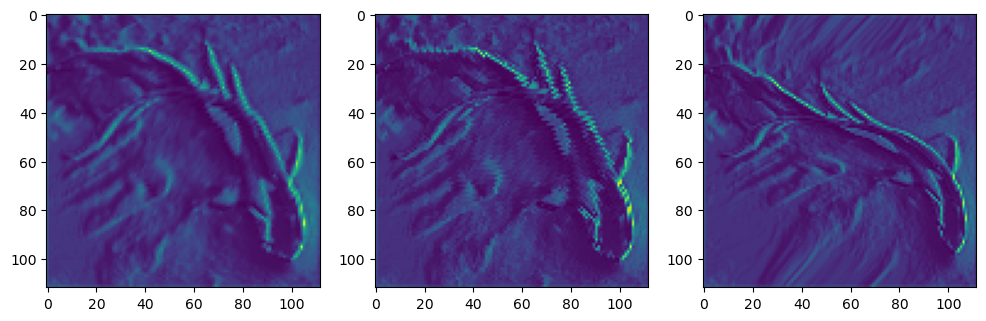

In [106]:
img = 50
channel = 6
fig, axes = plt.subplots(1, 4, figsize = (16,4))
axes[0].imshow(activation['bilinear'][img,channel].cpu())
axes[1].imshow(activation['nearest'][img,channel].cpu())
axes[2].imshow(activation['original'][img,channel].cpu())
axes[3].imshow(activation['svd_corr'][img,channel].cpu())

In [30]:
model_layer[5]

FusedMBConv(
  (block): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stochastic_depth): StochasticDepth(p=0.01, mode=row)
)

In [47]:
upsample_grid = sparse_diffeos.get_id_grid(224, 224)
grid_0 = sparse_diffeos.get_id_grid(112, 112)
image_0 = F.grid_sample(fav_image.to(device).unsqueeze(0), grid_0, align_corners = True)
image_1 = F.grid_sample(fav_image.to(device).unsqueeze(0), grid_1[0].unsqueeze(0), align_corners = True, mode='bilinear')
image_2 = F.grid_sample(image_1, grid_2[0].unsqueeze(0), align_corners = True, mode='bilinear')
image_3 = F.grid_sample(image_1, grid_1[0].unsqueeze(0), align_corners = True, mode='bilinear')

In [22]:
image_1 = F.grid_sample(image_0, upsample_grid, align_corners = False)

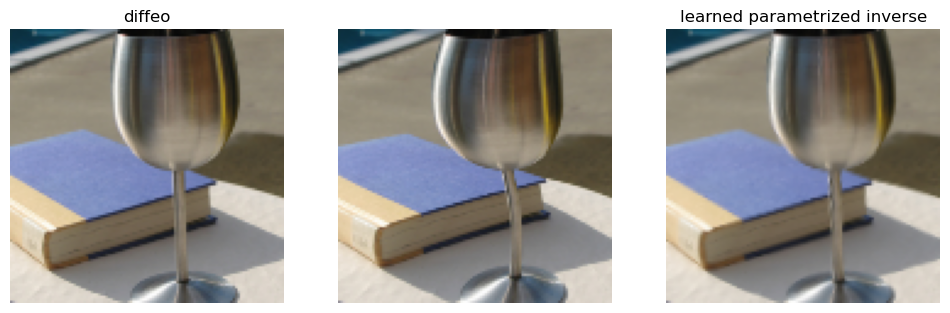

In [41]:
fig, axes = plt.subplots(1, 3, figsize = (12,4))
axes[0].imshow(toImage(image_0.detach().cpu().squeeze()))
axes[0].set_title('diffeo')
axes[1].imshow(toImage(image_1.detach().cpu().squeeze()))
axes[2].imshow(toImage(image_2.detach().cpu().squeeze()))
axes[2].set_title('learned parametrized inverse')
[ax.axis('off') for ax in axes];

In [48]:
U, S_ref, Vh = t.linalg.svd(fav_image)
U_0, S_0, Vh_0 = t.linalg.svd(image_0)
U_1, S_1, Vh_1 = t.linalg.svd(image_1)
U_2, S_2, Vh_2= t.linalg.svd(image_2)
U_3, S_3, Vh_3 = t.linalg.svd(image_3)

(0.0, 112.0)

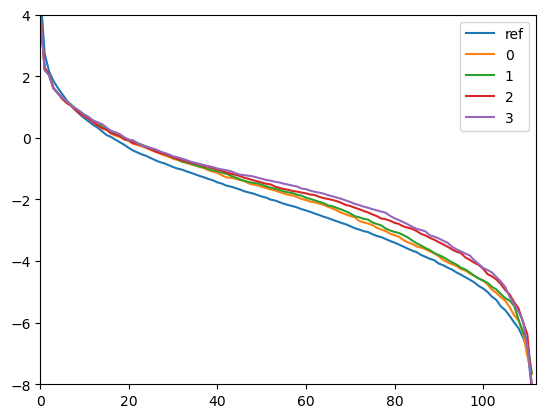

In [42]:
plt.plot(np.log((S_ref.mean(0)[::2]).detach().cpu().numpy().T), label = 'ref')

plt.plot(np.log((S_0.mean(1)).detach().cpu().numpy().T), label = '0')
plt.plot(np.log((S_1.mean(1)).detach().cpu().numpy().T), label = '1')
plt.plot(np.log((S_2.mean(1)).detach().cpu().numpy().T), label = '2')
plt.plot(np.log((S_3.mean(1)).detach().cpu().numpy().T), label = '3')
plt.legend()

plt.ylim(-8,4)
plt.xlim(0,112)

In [53]:
S_ref.shape

torch.Size([3, 224])

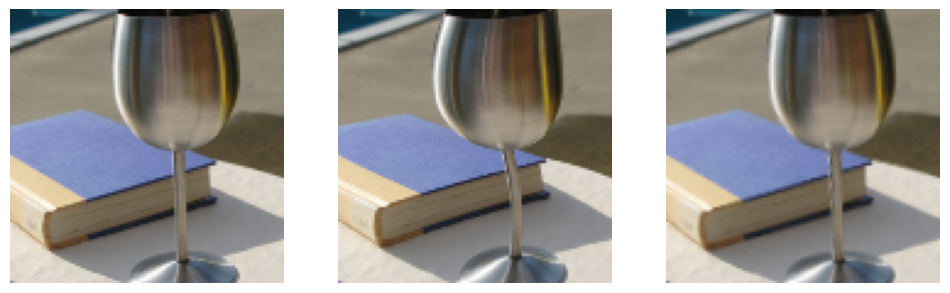

In [67]:
reconstruc = t.einsum('cik, ck, ckj -> cij',U_2[0], S_2[0], Vh_2[0])
blur_kernal = v2.GaussianBlur(kernel_size=(7,7), sigma = 0.2)
# high_res_1

fig, axes = plt.subplots(1, 3, figsize = (12,4))
axes[0].imshow(toImage(image_0.detach().cpu().squeeze()))
# axes[0].set_title('diffeo')
axes[1].imshow(toImage(blur_kernal(image_1).detach().cpu().squeeze()))
axes[2].imshow(toImage(reconstruc.detach().cpu().squeeze()))
# axes[2].set_title('learned parametrized inverse')
[ax.axis('off') for ax in axes];

In [39]:
steering_layer.block[0][1]

BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

In [153]:
ENV2.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_de